# Compare Representational Similarities

## Import Necessarly Libraries

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn
import segmentation_models as sm
sm.set_framework('tf.keras')

## Get Data

In [2]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images

fatal: destination path 'imagenet-sample-images' already exists and is not an empty directory.


## Test

2022-01-15 01:15:28.092697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-15 01:15:28.612575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20371 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6


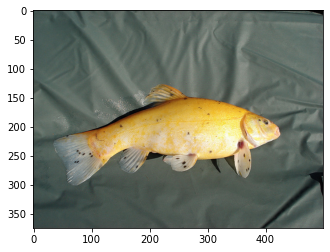

In [2]:
with open("imagenet-sample-images/n01440764_tench.JPEG", "rb") as f:
    img = tf.image.decode_jpeg(f.read())
plt.figure()
plt.imshow(img)

## Define Necessary Functions

In [28]:
def get_activation_model(model=None,layer_name=None):
    layer = None
    for l in model.layers:
        if l.name == layer_name:
            layer = l
    return tf.keras.Model(model.input, layer.output)
def get_activation_tensor(activation_model=None,stimuli_path=None,gray_scale=False):
    with open(stimuli_path, "rb") as f:
        img = tf.image.decode_jpeg(f.read())
    if not gray_scale:
        if img.shape[-1]==1:
            img = tf.image.grayscale_to_rgb(img)
    else:
        if img.shape[-1]==3:
            img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img,(256,256))
    #print(img.shape)
    activation = activation_model(tf.expand_dims(img, axis=0))
    return activation
def MSE(trained_tensor=None,untrained_tensor=None):
    return tf.keras.metrics.mean_squared_error(trained_tensor, untrained_tensor)

### Test

In [23]:
resnet152_cremi = keras.models.load_model("model_experiments/cremi_resnet152/model_weights/model_weights.ckpt")
resnet152_cremi_activation_model = get_activation_model(model=resnet152_cremi,layer_name="stage3_unit4_relu3")
cremi_activation = get_activation_tensor(activation_model=resnet152_cremi_activation_model,stimuli_path="imagenet-sample-images/n01440764_tench.JPEG",gray_scale=True)
cremi_activation.shape

TensorShape([1, 16, 16, 256])

In [5]:
resnet152_cremi.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 3136        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [24]:
resnet152_imagenet = sm.Unet('resnet152',classes=1,encoder_weights='imagenet', activation='sigmoid')
resnet152_imagenet.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_364 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_364[0][0]         
___________________________________________________________________________________________

In [25]:
resnet152_imagenet_activation_model = get_activation_model(model=resnet152_imagenet,layer_name="stage3_unit4_relu3")
imagenet_activation = get_activation_tensor(activation_model=resnet152_imagenet_activation_model,stimuli_path="imagenet-sample-images/n01440764_tench.JPEG",gray_scale=False)
imagenet_activation.shape

TensorShape([1, 16, 16, 256])

In [26]:
tf.norm(cremi_activation-imagenet_activation).numpy().squeeze()

2088.5996

## V1

In [7]:
# trained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights="imagenet")
# trained_resnet152_activation_model = get_activation_model(model=resnet152,layer_name="conv4_block1_out")

In [29]:
cremi_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            cremi_activations.append(get_activation_tensor(activation_model=resnet152_cremi_activation_model,stimuli_path=img,gray_scale=True))
        except ValueError:
            print(f'shape doesnt match for {img}')

In [ ]:
# untrained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights=None)
# untrained_resnet152_activation_model = get_activation_model(model=untrained_resnet152,layer_name="conv4_block1_out")

In [31]:
imagenet_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            imagenet_activations.append(get_activation_tensor(activation_model=resnet152_imagenet_activation_model,stimuli_path=img))
        except ValueError:
            print(f'shape doesnt match for {img}')

In [35]:
v1_MSEs = []
for cremi,imagenet in zip(cremi_activations,imagenet_activations):
    v1_MSEs.append(tf.norm(cremi-imagenet).numpy().squeeze())
print(max(v1_MSEs))
print(np.mean(v1_MSEs))
print(min(v1_MSEs))

12522.781
4041.9915
223.85143


Text(0.5, 1.0, 'Resnet 152 V1 CREMI vs ImageNet Euclidean Distance')

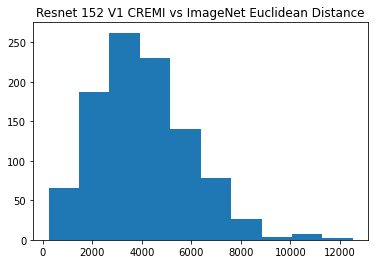

In [36]:
plt.hist(v1_MSEs)
plt.title("Resnet 152 V1 CREMI vs ImageNet Euclidean Distance")

## V2

In [37]:
# trained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights="imagenet")
cremi_activation_model = get_activation_model(model=resnet152_cremi,layer_name='stage3_unit12_relu3')

In [41]:
cremi_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            cremi_activations.append(get_activation_tensor(activation_model=cremi_activation_model,stimuli_path=img,gray_scale=True))
        except ValueError:
            print(f'shape doesnt match for {img}')

In [43]:
# untrained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights=None)
imagenet_activation_model = get_activation_model(model=resnet152_imagenet,layer_name="stage3_unit12_relu3")

In [44]:
imagenet_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            imagenet_activations.append(get_activation_tensor(activation_model=imagenet_activation_model,stimuli_path=img))
        except ValueError:
            print(f'shape doesnt match for {img}')

In [45]:
v2_MSEs = []
for cremi,imagenet in zip(cremi_activations,imagenet_activations):
    v2_MSEs.append(tf.norm(cremi-imagenet).numpy().squeeze())
print(max(v2_MSEs))
print(np.mean(v2_MSEs))
print(min(v2_MSEs))

35842.645
10726.528
229.18019


Text(0.5, 1.0, 'Euclidean Distances between CREMI and ImageNet Resnet152 in V2')

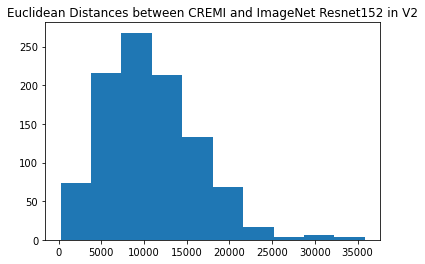

In [46]:
plt.hist(v2_MSEs)
plt.title("Euclidean Distances between CREMI and ImageNet Resnet152 in V2")

### IT

In [54]:
# trained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights="imagenet")
cremi_resnet152_activation_model = get_activation_model(model=resnet152_cremi,layer_name='stage3_unit36_relu3')

In [57]:
cremi_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            cremi_activations.append(get_activation_tensor(activation_model=cremi_resnet152_activation_model,stimuli_path=img, gray_scale=True))
        except ValueError:
            print(f'shape doesnt match for {img}')
len(cremi_activations)

1000

In [49]:
# untrained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights=None)
imagenet_resnet152_activation_model = get_activation_model(model=resnet152_imagenet,layer_name="stage3_unit36_relu3")

In [53]:
imagenet_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            imagenet_activations.append(get_activation_tensor(activation_model=imagenet_resnet152_activation_model,stimuli_path=img))
        except ValueError:
            print(f'shape doesnt match for {img}')
len(imagenet_activations)

1000

In [58]:
it_MSEs = []
for cremi,imagenet in zip(cremi_activations,imagenet_activations):
    it_MSEs.append(tf.norm(cremi-imagenet).numpy().squeeze())
print(len(it_MSEs))
print(max(it_MSEs))
print(np.mean(it_MSEs))
print(min(it_MSEs))

1000
253425.84
69382.19
172.31877


Text(0.5, 1.0, 'Euclidean Distance between ImageNet and CREMI Activations for Resnet152 IT Region')

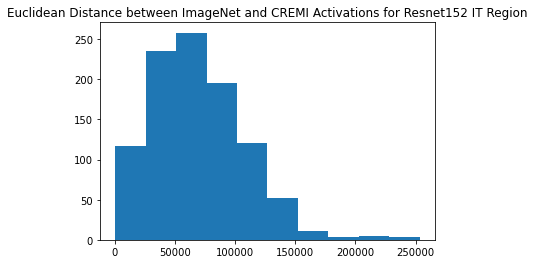

In [59]:
plt.hist(it_MSEs)
plt.title("Euclidean Distance between ImageNet and CREMI Activations for Resnet152 IT Region")

In [61]:
layer_index = []
layer_names = ['stage3_unit4_relu3','stage3_unit12_relu3','stage3_unit36_relu3']
for layer in layer_names:
    i=0
    for model_layer in resnet152_cremi.layers:
        if layer == model_layer.name:
            layer_index.append(i)
        i+=1

In [62]:
min_MSEs = [np.amin(v1_MSEs), np.amin(v2_MSEs), np.amin(it_MSEs)]
avg_MSEs = [np.mean(v1_MSEs), np.mean(v2_MSEs), np.mean(it_MSEs)]
max_MSEs = [np.amax(v1_MSEs), np.amax(v2_MSEs), np.amax(it_MSEs)]

Text(0.5, 1.0, 'layer depth vs minimum mean squared error for resnet 152')

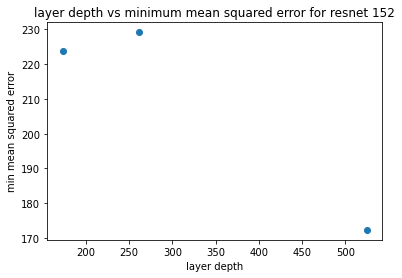

In [63]:
plt.scatter(layer_index, min_MSEs)
plt.xlabel("layer depth")
plt.ylabel("min mean squared error")
plt.title("layer depth vs minimum mean squared error for resnet 152")

Text(0.5, 1.0, 'layer depth vs average mean squared error for resnet 152')

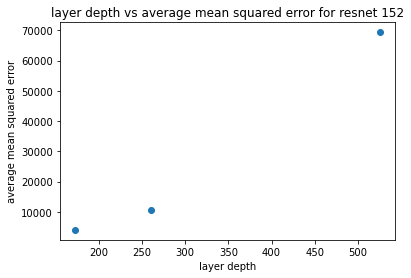

In [64]:
plt.scatter(layer_index, avg_MSEs)
plt.xlabel("layer depth")
plt.ylabel("average mean squared error")
plt.title("layer depth vs average mean squared error for resnet 152")

Text(0.5, 1.0, 'layer depth vs max mean squared error for resnet 152')

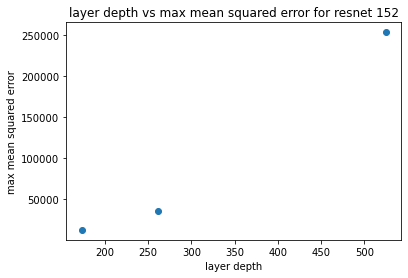

In [65]:
plt.scatter(layer_index, max_MSEs)
plt.xlabel("layer depth")
plt.ylabel("max mean squared error")
plt.title("layer depth vs max mean squared error for resnet 152")